- Aim: first attempt at coding the Markov Snippets SMC sampler with THUG mutation kernel, as described by Algorithm 1 in Christophe's notes. 
- Application: Here we apply it to the ellipse problem.
- Important: here we focus on $\alpha = 0$

A simplified version of Algorithm 1 is basically this:

- Initialize particles $z_0^{(1:N)}\sim \mu_0$.
- For each iteration $n=1, \ldots, P$: 
    1. Construct trajectories $z_{n-1, k}^{(1:N)}$ 
    2. Resample trajectory points down to $N$ particles using weights
    $$
    \bar{w}_{n, k} = \frac{\mu_n(z_{n-1, k}^{(i)})}{\mu_n(z_{n-1}^{(i)})}
    $$
    3. Rejuvenate velocities for the $N$ particles

In [232]:
import numpy as np
from numpy import zeros, eye, array, diag, exp
from numpy.linalg import solve, norm
from numpy.random import choice
from scipy.stats import multivariate_normal as MVN
import math

import matplotlib.pyplot as plt
from matplotlib import rc

from Manifolds.GeneralizedEllipse import GeneralizedEllipse
from utils import prep_contour
from RWM import RWM
from tangential_hug_functions import HugTangential

#### Settings for the Ellipse and Filamentary Distributions

In [57]:
μ  = zeros(2)
Σ  = diag(array([0.1, 1]))
level_set_value = -2.9513586307684885
ellipse = GeneralizedEllipse(μ, Σ, exp(level_set_value))
πellipse = MVN(μ, Σ)
f = πellipse.logpdf
grad_f = lambda ξ: -solve(Σ, ξ - μ)

# def generate_logpi(ϵ):
#     """Generates η_ϵ."""
#     return lambda ξ: -np.linalg.norm(f(ξ) - level_set_value)**2/(2*(ϵ**2)) - np.log(ϵ)

def generate_ηϵ(ϵ):
    """Generates ηϵ with a uniform kernel."""
    def ηϵ(x):
        if np.linalg.norm(f(x) - level_set_value) <= ϵ:
            return 1.0
        else: 
            return 0.0
    return ηϵ

def generate_logηϵ(ϵ):
    """As above, this is for the uniform kernel but this computes the log density."""
    def logηϵ(ξ):
        with np.errstate(divide='ignore'):
            return np.log(float(norm(f(ξ) - level_set_value) <= ϵ) / ϵ)
    return logηϵ

In [24]:
def find_bounding_box_for_ellipse(n):
    """Computes lots of samples of the ellipse to try and find a bounding box for it."""
    overall_minimum = 0.0
    overall_maximum = 0.0
    
    for i in range(n):
        point = ellipse.sample(advanced=True)
        minimum, maximum = np.min(point), np.max(point)
        if minimum < overall_minimum:
            overall_minimum = minimum
        if maximum > overall_maximum:
            overall_maximum = maximum
    
    return overall_minimum, overall_maximum

In [25]:
# find_bounding_box_for_ellipse(1000)  # run with 10k and min=-5, max=5

#### Settings for the THUG kernel

In [26]:
B = 20
δ = 0.1

In [467]:
def THUGIntegratorUnivariate(z0, B, δ, grad):
    """THUG Integrator for the 2D example (ie using gradients, not jacobians)."""
    trajectory = zeros((B + 1, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for b in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
        trajectory[b+1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorUnivariate(B, δ):
    """Returns a THUG integrator for a given B and δ."""
    grad = lambda ξ: -solve(Σ, ξ - μ) #ellipse.Q(ξ).T.flatten()
    integrator = lambda z: THUGIntegratorUnivariate(z, B, δ, grad)
    return integrator

###############################
#### this is for \tilde{ψ}.
###############################
def THUGIntegratorUnivariateOnlyEnd(z0, B, δ, grad):
    """Similar to THUG integrator but one step does B bounces."""
    trajectory = zeros((2, len(z0)))
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    trajectory[0, :] = z0
    # Integrate
    for _ in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
    trajectory[1, :] = np.hstack((x, v))
    return trajectory

def generate_THUGIntegratorUnivariateOnlyEnd(B, δ):
    """Returns a THUG integratorOnlyEnd for a given B and δ."""
    grad = lambda ξ: -solve(Σ, ξ - μ) #ellipse.Q(ξ).T.flatten()
    integrator = lambda z: THUGIntegratorUnivariateOnlyEnd(z, B, δ, grad)
    return integrator


#### Metropolis-Hastings version for SMC version
def THUG_MH(z0, B, δ, logpi):
    """Similar to THUGIntegratoUnivariateOnlyEnd but this uses a MH step."""
    grad = lambda ξ: -solve(Σ, ξ - μ)
    x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
    x, v = x0, v0
    logu = np.log(np.random.rand())
    for _ in range(B):
        x = x + δ*v/2
        g = grad(x)
        ghat = g / norm(g)
        v = v - 2*ghat*(ghat@v)
        x = x + δ*v/2
    if logu <= logpi(x) - logpi(x0):
        # accept new point
        return np.concatenate((x, v))
    else:
        # accept old point
        return z0

In [28]:
# def THUGIntegratorMultivariate(z0, B, δ, jac):
#     """THUG integrator for the MarkovSnippets example in D>2 example."""
#     project = lambda v, J: J.T.dot(solve(J.dot(J.T), J.dot(v)))  # linear projection
#     trajectory = zeros((B + 1, len(z0)))
#     x0, v0 = z0[:len(z0)//2], z0[len(z0)//2:]
#     x, v = x0, v0
#     trajectory[0, :] = z0
#     # Integrate
#     for b in range(B):
#         x = x + δ*v/2
#         v = v - 2*project(v, jac(x))
#         x = x + δ*v/2
#         trajectory[b+1, :] = np.hstack((x, v))
#     return trajectory

# def generate_THUGIntegratorMultivariate(B, δ):
#     """Returns a THUG integrator for a given B and δ."""
#     jac = lambda ξ: ellipse.Q(ξ).T
#     integrator = lambda z: THUGIntegratorMultivariate(z, B, δ, jac)
#     return integrator

In [354]:
class MarkovSnippetsTHUG:
    
    def __init__(self, N, B, δ, d, ϵs, onlyend=False):
        """Markov Snippets SMC samplers corresponding exactly to Algorithm 1 in Christophe's notes.
        It uses the THUG kernel as its mutation kernel. The sequence of distributions is fixed here 
        since we provide ϵs, i.e. a list of tolerances which automatically fully specify the posterior 
        distributions used at each round.
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        
        :param onlyend: If False, we just run MS-SMC with the THUG integrator as kernel. If True, the THUG 
                        integrator is pretty much the same, but it only outputs the initial and final point, 
                        as part of the trajectory. Inside the integrator, it still performs B bounces, but 
                        basically we are changing \psi to \tilde{\psi} which performs B steps at once, and we 
                        run it only once.
        :type onlyend: bool
        """
        # Input variables
        self.N  = N       
        self.B  = B
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ϖ  = MVN(zeros(d), eye(d))                             # Distribution of the velocities
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
#         self.μs = [lambda z: ηϵ(z[:self.d]) for ηϵ in self.ηs]
        if not onlyend:
            self.ψ = generate_THUGIntegratorUnivariate(B, δ)
        else:
            self.ψ = generate_THUGIntegratorUnivariateOnlyEnd(B, δ)
            self.B = 1
    
    def initialize_particles(self):
        """To initialize particles, we sample from a uniform on a large rectangle.
        A rectangle of size [-100, 100] should be plenty large."""
# #         # Sample x-component from the uniform, i.e. uniform on a large enough rectangle
#         x0 = np.random.uniform(low=-20, high=20, size=(self.N, self.d))
#         # Try initializing particles on the manifold itself
# #         x0 = np.vstack([ellipse.sample(advanced=True) for _ in range(self.N)])
#         # Sample v-component from normal distribution
#         v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
#         # Collate together
#         z0 = np.hstack((x0, v0))
#         return z0
        # Initialize particles by sampling from η_ϵ0 for a large ϵ0 which can be given as an argument.
        # Sample a point from the prior
        x0 = ellipse.sample(advanced=True) #np.random.uniform(low=-5, high=5, size=(self.d))
        # Use RWM starting from z0
#         ηϵ0    = generate_ηϵ(ϵ0)
#         logηϵ0 = generate_logηϵ(ϵ0)
#         self.μs = np.r_[lambda z: ηϵ0(z[:self.d]), self.μs]
#         self.ϵs = np.r_[ϵ0, self.ϵs]
        logηϵ0 = generate_logηϵ(self.ϵs[0])
#         print("initializing with ϵ0=", self.ϵs[0])
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
#         print(np.apply_along_axis(generate_ηε(self.ϵs[0]), 1, initialized_particles))
#         print(np.apply_along_axis(lambda x: np.exp(logηϵ0(x)), 1, initialized_particles))
#         print(np.apply_along_axis(self.ηs[0], 1, initialized_particles))
#         print(np.apply_along_axis(self.μs[0], 1, initialized_particles))
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        N = self.N
        B = self.B
        ## Storage
        #### Store z_n^{(i)}
        self.ZN  = np.zeros((self.P+1, N, 2*self.d))
        #### Store z_{n, k}^{(i)} so basically all the N(T+1) particles
        self.ZNK  = np.zeros((self.P, N*(B+1), 2*self.d))
        self.Wbar = np.zeros((self.P, N*(B+1)))
        self.ESS  = np.zeros((self.P))
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        self.ZN[0] = z
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Compute trajectories
            Z = np.apply_along_axis(self.ψ, 1, z) # should have shape (N, B+1, 2d)
            self.ZNK[n-1] = Z.reshape(N*(B+1), 2*self.d)
            # Compute weights.
            #### Denominator: shared for each point in the same trajectory
            μnm1_z  = np.apply_along_axis(self.ηs[n-1], 1, Z[:, 0, :self.d])              # (N, )
            μnm1_z  = np.repeat(μnm1_z, self.B+1, axis=0).reshape(N, B+1) # (N, B+1)
            #### Numerator: different for each point on a trajectory.
            μn_ψk_z = np.apply_along_axis(self.ηs[n], 2, Z[:, :, :self.d])                         # (N, B+1)
            #### Put weights together
            W = μn_ψk_z / μnm1_z #np.exp(log_μn_ψk_z - log_μnm1_z)
            #### Normalize weights
            W = W / W.sum()
            # store weights (remember these are \bar{w})
            self.Wbar[n-1] = W.flatten()
            # compute ESS
            self.ESS[n-1] = 1 / np.sum(W**2)
            # Resample down to N particles
            resampling_indeces = choice(a=np.arange(N*(B+1)), size=N, p=W.flatten())
            indeces = np.dstack(np.unravel_index(resampling_indeces, (N, B+1))).squeeze()
            z = np.vstack([Z[tuple(ix)] for ix in indeces])     # (N, 2d)
            
            # Rejuvenate velocities of N particles
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(N, self.d))
            self.ZN[n] = z
        return z

In [355]:
# At this point, doesn't really matter which ϵs we use.
ϵs = [10, 2, 0.5, 0.1]
B = 20
δ = 0.1
N  = 2000
# Instantitate the algorithm
MSTHUG = MarkovSnippetsTHUG(N=N, B=B, δ=δ, d=2, ϵs=ϵs)

In [356]:
# Sample
zP = MSTHUG.sample()

In [357]:
# fig, ax = plt.subplots()
# ax.contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value])
# ax.scatter(*zP[:, :2].T)
# ax.set_aspect("equal")

In [358]:
# initializer = MarkovSnippetsTHUG(N=100, B=20, δ=0.1, d=2, ϵs=ϵs)
# rwm_initialized_particles = initializer.initialize_particles(ϵ0=5)

In [359]:
# fig, ax = plt.subplots()
# ax.contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value])
# ax.scatter(*rwm_initialized_particles[:, :2].T)
# ax.set_aspect("equal")

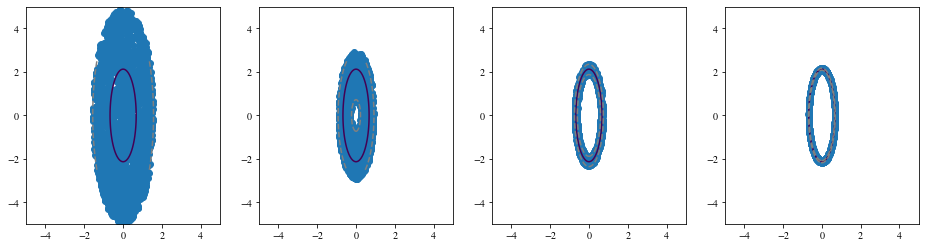

In [360]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value])
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value-MSTHUG.ϵs[i], level_set_value+MSTHUG.ϵs[i]], colors='gray')
    ax[i].scatter(*MSTHUG.ZN[i, :, :2].T)
    ax[i].set_xlim([-5, 5])
    ax[i].set_ylim([-5, 5])

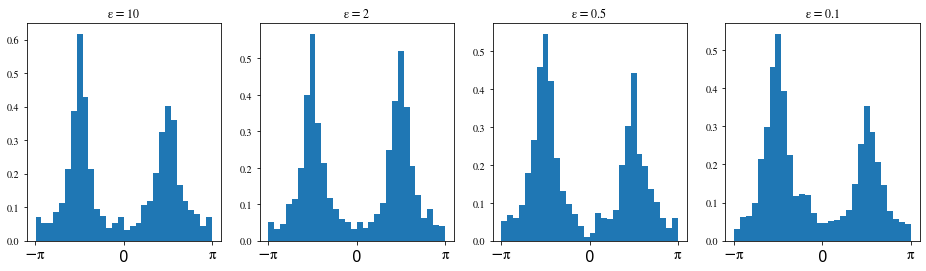

In [361]:
compute_arctan = lambda point: math.atan2(*point[::-1])
rc('font',**{'family':'STIXGeneral'})

fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
    _ = ax[i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG.ZN[i, :, :2]), bins=30, density=True)
    ax[i].set_xticks([-math.pi, 0, math.pi])
    ax[i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[i]))

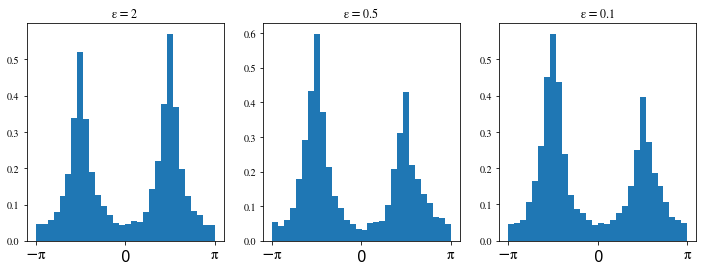

In [362]:
### This uses all N(T+1) particles and their w̄. 
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i in range(3):
    _ = ax[i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG.ZNK[i, :, :2]), bins=30, density=True, weights=MSTHUG.Wbar[i])
    ax[i].set_xticks([-math.pi, 0, math.pi])
    ax[i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[i+1]))

In [364]:
# The aim now is to only output the end of the trajectory with ψ.
MSTHUG_ONLYEND = MarkovSnippetsTHUG(N=N, B=B, δ=δ, d=2, ϵs=ϵs, onlyend=True)

In [365]:
zP_onlyend = MSTHUG_ONLYEND.sample()

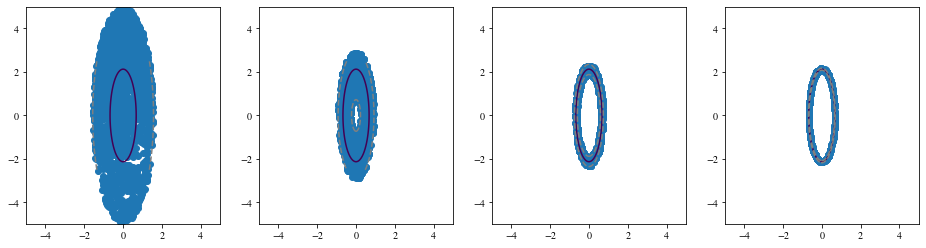

In [366]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value])
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value-MSTHUG_ONLYEND.ϵs[i], level_set_value+MSTHUG_ONLYEND.ϵs[i]], colors='gray')
    ax[i].scatter(*MSTHUG_ONLYEND.ZN[i, :, :2].T)
    ax[i].set_xlim([-5, 5])
    ax[i].set_ylim([-5, 5])

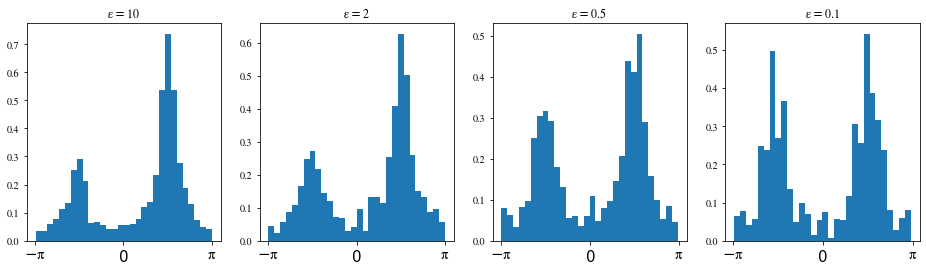

In [367]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
    _ = ax[i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG_ONLYEND.ZN[i, :, :2]), bins=30, density=True)
    ax[i].set_xticks([-math.pi, 0, math.pi])
    ax[i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[i]))

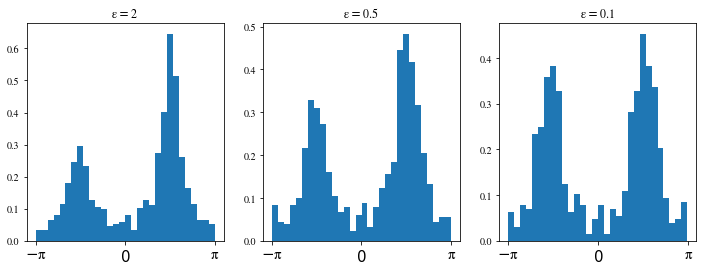

In [368]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i in range(3):
    _ = ax[i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG_ONLYEND.ZNK[i, :, :2]), bins=30, density=True, weights=MSTHUG_ONLYEND.Wbar[i])
    ax[i].set_xticks([-math.pi, 0, math.pi])
    ax[i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[i+1]))

In [515]:
class MarkovSnippetsTHUGMetropolised:
    
    def __init__(self, N, B, δ, d, ϵs):
        """Metropolised version: for each particle compute the endpoint of trajectory and its weight.
        If the weight is positive, we accept the final point, otherwise we accept the initial point. 
        
        Parameters
        ----------
        
        :param N: Number of particles
        :type N:  int
        
        :param B: Number of bounces for the THUG integrator. Equivalent to `L` Leapfrog steps in HMC.
        :type B: int
        
        :param δ: Step-size used at each bounce, for the THUG integrator.
        :type δ: float
        
        :param d: Dimensionality of the `x` component of each particle, and equally dimensionality of 
                  `v` component of each particle. Therefore each particle has dimension `2d`.
        
        :param ϵs: Tolerances that fully specify the sequence of target filamentary distributions.
        :type ϵs: iterable
        """
        # Input variables
        self.N  = N       
        self.δ  = δ
        self.d  = d
        self.ϵs = ϵs       
        
        # Variables derived from the above
        self.P  = len(ϵs) - 1                                       # Number of target distributions
        self.ϖ  = MVN(zeros(d), eye(d))                             # Distribution of the velocities
        self.ηs = [generate_ηϵ(ϵ) for ϵ in ϵs]                      # List of filamentary distributions 
        
        self.B = B
    
    def initialize_particles(self):
        """To initialize particles, we sample from a uniform on a large rectangle.
        A rectangle of size [-100, 100] should be plenty large."""
        # Initialize particles by sampling from η_ϵ0 for a large ϵ0 which can be given as an argument.
        # Sample a point from the prior
        x0 = ellipse.sample(advanced=True) #np.random.uniform(low=-5, high=5, size=(self.d))
        # Use RWM starting from x0
        logηϵ0 = generate_logηϵ(self.ϵs[0])
        burn_in = 100
        TO_BE_THINNED, _ = RWM(x0, self.δ, burn_in + 10*self.N, logηϵ0)
        # Thin the samples to obtain the particles
        initialized_particles = TO_BE_THINNED[burn_in:][::10]
        v0 = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
        z0 = np.hstack((initialized_particles, v0))
        self.starting_particles = z0
        return z0
        
    def sample(self):
        """Starts the Markov Snippets sampler."""
        # Store z_n^{(i)}
#         self.ZN  = np.zeros((self.P+1, self.N, 2*self.d))
        # Initialize particles
        z = self.initialize_particles()   # (N, 2d)
        # Storage
        self.PARTICLES    = zeros((self.P+1, self.N, 2*self.d))
        self.PARTICLES[0] = z
        self.WEIGHTS      = zeros((self.P+1, self.N))
        self.WEIGHTS[0]   = 1 / self.N
        # For each target distribution, run the following loop
        for n in range(1, self.P+1):
            # Standard SMC sampler, we mutate the particles and then we resample
            ### Mutation step: 
            ###### Refresh velocities
            z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(self.N, self.d))
            ###### Mutate positions 
            M = lambda z: THUG_MH(z, B, self.δ, self.ηs[n-1])
            Z = np.apply_along_axis(M, 1, z)
            ### Compute weights
            w = (abs(np.apply_along_axis(f, 1, Z[:, :2]) - level_set_value) <= self.ϵs[n]).astype(float)
            w = w / w.sum()
            self.WEIGHTS[n] = w
            ### Resample
            indeces = choice(a=np.arange(self.N), size=self.N, p=w)
            z = z[indeces, :]
            self.PARTICLES[n] = z
            #### The idea here is to compute the endpoints and their weights. if the weights are positive 
            #### then we accept the endpoints as the new particles. Otherwise, we accept the initial (and 
            #### current) point.
            # Compute trajectories
#             Z = np.apply_along_axis(self.ψ, 1, z) # should have shape (N, 2, 2d)
            # Compute weights.
#             #### Denominator: shared for each point in the same trajectory
#             μnm1_z  = np.apply_along_axis(self.ηs[n-1], 1, Z[:, 0, :self.d])              # (N, )
#             μnm1_z  = np.repeat(μnm1_z, self.B+1, axis=0).reshape(N, B+1) # (N, B+1)
#             #### Numerator: different for each point on a trajectory.
#             μn_ψk_z = np.apply_along_axis(self.ηs[n], 2, Z[:, :, :self.d])                         # (N, B+1)
#             #### Put weights together
#             W = μn_ψk_z / μnm1_z #np.exp(log_μn_ψk_z - log_μnm1_z)
#             #### Normalize weights
#             W = W / W.sum()  # has shape (N, B+1) which in this case is (N, 2)
            #### Now basically look at the last column and see if they're positive
#             #### If they are positive, take the endpoints, otherwise take initial point
#             z = np.where(W[:, 1:] > 0, Z[:, -1, :], Z[:, 0, :])
#             print((W[:, 1:] > 0).sum(), (z == Z[:, -1, :]).all(axis=1).sum())
            # Resample down to N particles, now resampling done on these mutated particles
            # the resampling now is uniform because all particles have weight proportional to 1.
#             indeces = choice(a=np.arange(N), size=N, p=np.full(N, 1/N))
#             z = z[indeces, :]
            # Rejuvenate velocities of N particles
#             z[:, self.d:] = np.random.normal(loc=0.0, scale=1.0, size=(N, self.d))
#             self.ZN[n] = z
        return z

In [516]:
# right now the problem is that after the first iteration, it seems that we reject everything.

In [517]:
MSTHUG_METROP = MarkovSnippetsTHUGMetropolised(N=N, B=B, δ=δ, d=2, ϵs=ϵs)
zP_metrop = MSTHUG_METROP.sample()

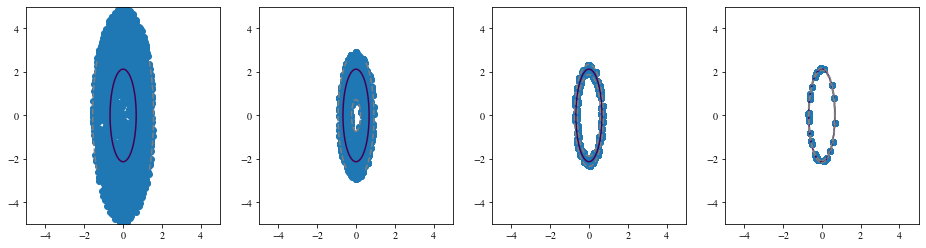

In [519]:
fig, ax = plt.subplots(ncols=4, figsize=(16, 4))
for i in range(4):
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value])
    ax[i].contour(*prep_contour([-2.5, 2.5], [-2.5, 2.5], 0.01, f), levels=[level_set_value-MSTHUG_METROP.ϵs[i], level_set_value+MSTHUG_METROP.ϵs[i]], colors='gray')
    ax[i].scatter(*MSTHUG_METROP.PARTICLES[i, :, :2].T)
    ax[i].set_xlim([-5, 5])
    ax[i].set_ylim([-5, 5])

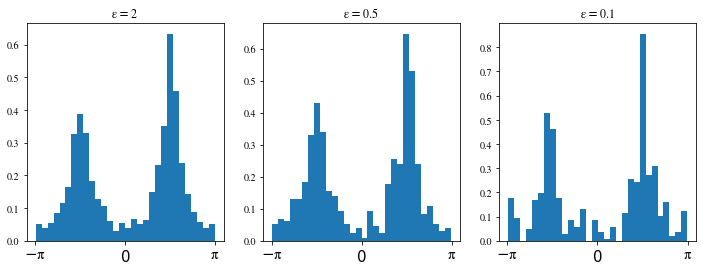

In [520]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
for i in range(3):
    _ = ax[i].hist(np.apply_along_axis(compute_arctan, 1, MSTHUG_METROP.PARTICLES[i, :, :2]), bins=30, density=True, weights=MSTHUG_METROP.WEIGHTS[i])
    ax[i].set_xticks([-math.pi, 0, math.pi])
    ax[i].set_xticklabels([r'$-\mathregular{\pi}$', r'$0$', r'$\mathregular{\pi}$'], fontsize=15)
    ax[i].set_title(r'$\mathregular{\epsilon}=$' + '{}'.format(ϵs[i+1]))

- use $\tilde{\psi} = \psi^T$ for $\tilde{T} = 1$
    - V1: keep initial and final point
    - V2: keep only final point
- Unfold ellipse $[0, 2\pi]$ and show histogram for both algorithms, use $N(T+1)$ particles for histogram. 
- ESS for $N(T+1)$ particles, and ESS for $2N$ particles (SMC version - count $1$s)
- Check functionals e.g. $x$, $x^2$

$$\mathbb{I}(\|f(x) - y\| \leq \epsilon)$$

$$
- \epsilon \leq f(x) - y \leq \epsilon
$$

$$
f^{(i)} 
$$